/project/ssverma_shared/projects/Endometriosis/Endo_Subtyping_Heterogeneity


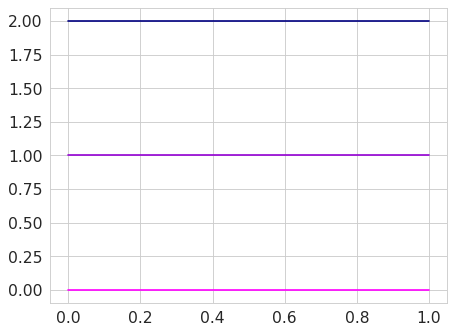

In [10]:
# Imports, configuration

import pandas as pd
import numpy as np
import re
import gzip
import os
import warnings
import subprocess as sub
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import importlib
import manhattan_plot
import boroughs_plot

mpl.rcParams['figure.dpi'] = 80
mpl.rcParams.update({'font.size': 14})
%config IPCompleter.use_jedi = False
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
import pickle
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.patches as mpatches

# Get to appropriate working directory, print list of input files for convenience

os.chdir('/project/ssverma_shared/projects/Endometriosis/Endo_Subtyping_Heterogeneity/')
print(os.getcwd())

colors = ['fuchsia',
          'darkviolet',
          'navy',
          'dodgerblue',
          'mediumspringgreen',
          'g']
colors = colors[:3]

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

for i in range(len(colors)):
    plt.plot([0, 1], [i, i])

plt.show()

new_cmap = mpl.colors.ListedColormap(colors)

colors2 = [c for c in colors]
colors2.insert(0, 'k')
new_cmap2 = mpl.colors.ListedColormap(colors2)

os.makedirs('Manuscript_Plots', exist_ok=True)

In [2]:
original_data='Cluster_Training/Data/non_genotyped_PMBB_data_for_no_snps_clustering.csv'
genes_factors = pd.read_csv(original_data, index_col='IID')
og_dist = pd.DataFrame(pairwise_distances(genes_factors, metric='manhattan'), index=genes_factors.index, columns=genes_factors.index)
np.fill_diagonal(og_dist.values, np.nan)

[-0.5  1.5  3.5  5.5  7.5  9.5 11.5 13.5 15.5]
['0-1', '2-3', '4-5', '6-7', '8-9', '10-11', '12-13', '14-15']
5 10 20 50 100 200 500 1000 
                   ID1                ID2  Label     N  TSNE_Avg_Dist  \
0    PMBB5528597425436  PMBB3182768688436    0-1     5       0.533207   
1    PMBB8524490766048  PMBB9684634042552    0-1     5       0.008726   
2    PMBB6967413954551  PMBB3654715898272    0-1     5       0.216706   
3    PMBB4428599249013  PMBB2053597228891    0-1     5       0.397310   
4    PMBB6475832529875  PMBB9184387274843    0-1     5       0.129851   
..                 ...                ...    ...   ...            ...   
995  PMBB9192837065026  PMBB9311436998960  14-15  1000       0.709513   
996  PMBB8458655913014  PMBB9711666801518  14-15  1000       0.406045   
997  PMBB4526291479245  PMBB8458655913014  14-15  1000       0.646518   
998  PMBB9704470919189  PMBB1348122985349  14-15  1000       0.454855   
999  PMBB5977829758775  PMBB7107211180256  14-15  1000    

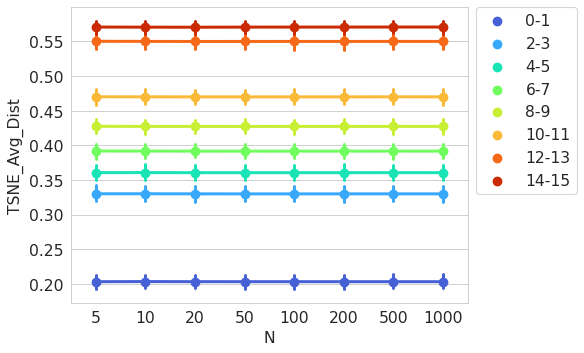

In [3]:
number_test_pairs_each = 1000

test_pair_values = np.arange(og_dist.min().min() - 0.5, og_dist.max().max() + 0.6, 2)

print(test_pair_values)

test_pairs = {}
pair_set_names = (test_pair_values[1:] + test_pair_values[:-1]) / 2
pair_set_names = [str(i * 2) + '-' + str(i * 2 + 1) for i in range(len(pair_set_names))]
print(pair_set_names)

for i, v in enumerate(test_pair_values[:-1]):
    left_bound = v
    right_bound = test_pair_values[i+1]
    r, c = np.where((left_bound < og_dist) & (og_dist <= right_bound))
    np.random.seed(int(314159+v))
    keep_coords = np.random.choice(list(range(len(r))), size=min(number_test_pairs_each, len(r)), replace=False)
    # keep_coords = np.arange(len(r))
    r2, c2 = r[keep_coords], c[keep_coords]
    test_pairs[pair_set_names[i]] = []
    for r_idx, c_idx in zip(r2, c2):
        test_pairs[pair_set_names[i]].append((og_dist.index[r_idx], og_dist.columns[c_idx]))

plot_data = []

N_LIST = [5, 10, 20, 50, 100, 200, 500, 1000]
for i, N in enumerate(N_LIST):
    print(N, end=' ')
    f = 'Cluster_Training/TSNE_Avg_no_SNPs/avg_dist_mtx_{n}.csv'.format(n=N)
    df = pd.read_csv(f, index_col='IID', dtype={'IID': str})

    for k, pairs in test_pairs.items():
        quantile_data = pd.DataFrame()
        quantile_data['ID1'] = [p1 for p1, p2 in pairs]
        quantile_data['ID2'] = [p2 for p1, p2 in pairs]
        quantile_data['Label'] = k
        quantile_data['N'] = N_LIST[i]
        quantile_data['TSNE_Avg_Dist'] = np.diagonal(df.loc[quantile_data['ID1'], quantile_data['ID2']].values)
        quantile_data['Original_Dist'] = np.diagonal(og_dist.loc[quantile_data['ID1'], quantile_data['ID2']].values)

        plot_data.append(quantile_data)

print()
plot_df = pd.concat(plot_data)
print(plot_df)

sns.pointplot(data=plot_df, x='N', y='TSNE_Avg_Dist', hue='Label', palette='turbo', errorbar='se')
plt.legend(bbox_to_anchor=(1.02, 1),loc='upper left',borderaxespad=0)
plt.savefig('Manuscript_Plots/distance_stability_point_plot.png', dpi=150, bbox_inches='tight')
plt.show()

[-0.5  1.5  3.5  5.5  7.5  9.5 11.5 13.5 15.5]
['0-1', '2-3', '4-5', '6-7', '8-9', '10-11', '12-13', '14-15']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
                   ID1                ID2  Label  TSNE_Avg_Dist  Original_Dist
0    PMBB6351424717216  PMBB8497452386164    0-1       0.014836            0.0
1    PMBB2303614528644  PMBB6621466331817    0-1       0.054983            0.0
2    PMBB8215673222315  PMBB8648312419596    0-1       0.030463            0.0
3    PMBB1692150981226  PMBB5738365109643    0-1       0.036680            0.0
4    PMBB6351424717216  PMBB5309226718240    0-1       0.084979            0.0
..                 ...                ...    ...            ...            ...
995  PMBB8458655913014  PMBB8835546185437  14-15       0.362891           13.0
996  PMBB5278293485907  PMBB5233086578851  14-15       0.672407           13.0
997  PMBB1699444604804  PMBB6769178900441  14-15       0.610096           13.0
998  PMBB6502691354649  PMBB8199846012284  14-15 

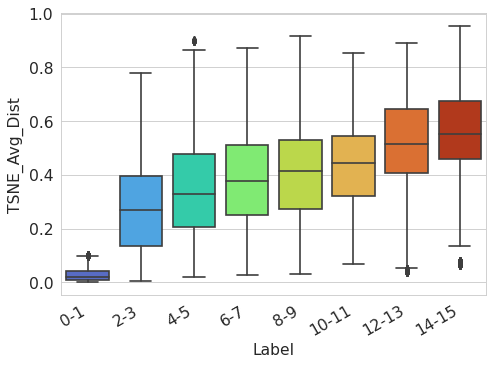

In [4]:
number_test_pairs_each = 1000

test_pair_values = np.arange(og_dist.min().min() - 0.5, og_dist.max().max() + 0.6, 2)
print(test_pair_values)

test_pairs = {}
pair_set_names = (test_pair_values[1:] + test_pair_values[:-1]) / 2
pair_set_names = [str(i * 2) + '-' + str(i * 2 + 1) for i in range(len(pair_set_names))]
print(pair_set_names)

for i, v in enumerate(test_pair_values[:-1]):
    r, c = np.where((v-1 <= og_dist) & (og_dist <= v+1))
    np.random.seed(int(314159+v))
    keep_coords = np.random.choice(list(range(len(r))), size=min(number_test_pairs_each, len(r)), replace=False)
    r2, c2 = r[keep_coords], c[keep_coords]
    test_pairs[pair_set_names[i]] = []
    for r_idx, c_idx in zip(r2, c2):
        test_pairs[pair_set_names[i]].append((og_dist.index[r_idx], og_dist.columns[c_idx]))

plot_data = []

for i in range(20):
    print(i, end=' ')
    f = 'Cluster_Training/TSNE_Random_Avg_no_SNPs/avg_dist_mtx_{i}_200.csv'.format(i=i)
    df = pd.read_csv(f, index_col='IID', dtype={'IID': str})
    for k, pairs in test_pairs.items():
        quantile_data = pd.DataFrame()
        quantile_data['ID1'] = [p1 for p1, p2 in pairs]
        quantile_data['ID2'] = [p2 for p1, p2 in pairs]
        quantile_data['Label'] = k
        quantile_data['TSNE_Avg_Dist'] = np.diagonal(df.loc[quantile_data['ID1'], quantile_data['ID2']].values)
        quantile_data['Original_Dist'] = np.diagonal(og_dist.loc[quantile_data['ID1'], quantile_data['ID2']].values)

        plot_data.append(quantile_data)

print()
plot_df = pd.concat(plot_data)
print(plot_df)

sns.boxplot(data=plot_df, y='TSNE_Avg_Dist', x='Label', palette='turbo')
# plt.legend(bbox_to_anchor=(1.02, 1),loc='upper left',borderaxespad=0)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig('Manuscript_Plots/random_stability_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

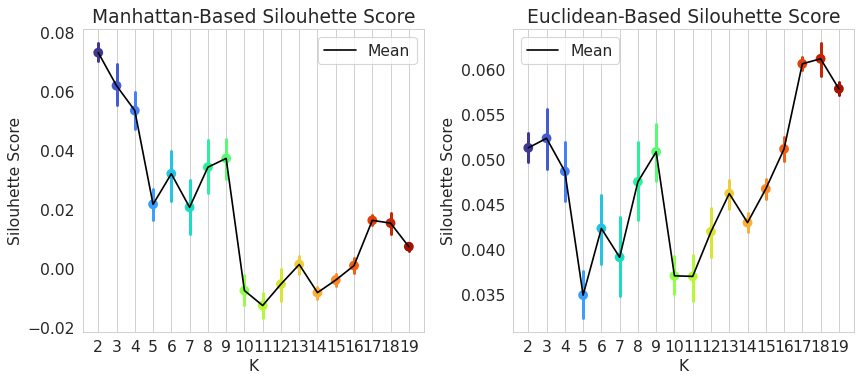

In [5]:
k_tests = pd.read_csv('Cluster_Training/Data/merged_k_tests_long.csv')

# fig, axes = plt.subplots(ncols=3, nrows=1, gridspec_kw={'width_ratios': [1, 1, 0.1]})
fig, axes = plt.subplots(ncols=2, nrows=1)

fig.set_size_inches(11, 5)

sns.pointplot(data=k_tests, x='K', y='Manhattan', palette='turbo', ax=axes[0])
sns.pointplot(data=k_tests, x='K', y='Euclidean', palette='turbo', ax=axes[1])

# norm = mpl.colors.Normalize(vmin=2, vmax=19)
norm = mpl.colors.BoundaryNorm(np.arange(1.5, 20.5), ncolors=256)
sm = mpl.cm.ScalarMappable(norm, cmap='turbo')
# plt.colorbar(sm, cax=axes[2])
# axes[2].set_yticks(np.arange(2, 20))

axes[0].plot(np.arange(18), k_tests.groupby('K')['Manhattan'].mean(), label='Mean', c='k')
axes[1].plot(np.arange(18), k_tests.groupby('K')['Euclidean'].mean(), label='Mean', c='k')

axes[0].grid()
axes[1].grid()

axes[0].set_ylabel('Silouhette Score')
axes[1].set_ylabel('Silouhette Score')

axes[0].set_title('Manhattan-Based Silouhette Score')
axes[1].set_title('Euclidean-Based Silouhette Score')

for ax in axes[:2].flatten():
    ax.legend()

plt.tight_layout()
plt.savefig('Manuscript_Plots/pointplots_NG_PMBB_silouhette_scores_k_tests.png', bbox_inches='tight')
plt.show()

In [6]:
tsne = TSNE(n_components=2, init='pca', perplexity=50, random_state=314159, metric='manhattan')
embedding = pd.DataFrame(tsne.fit_transform(genes_factors), columns=['TSNE 1', 'TSNE 2'], index=genes_factors.index)


/home/guarelin/mambaforge/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/guarelin/mambaforge/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [8]:
tsne_dist_mtx = pd.read_csv('Cluster_Training/TSNE_Random_Avg_no_SNPs/avg_dist_mtx_0_200.csv', index_col='IID', dtype={'IID': str})

asymmetric = tsne_dist_mtx.loc[np.any(tsne_dist_mtx != tsne_dist_mtx.transpose(), axis=1),
                               np.any(tsne_dist_mtx != tsne_dist_mtx.transpose(), axis=0)]
print(asymmetric)

a_idx = asymmetric.index

# manually fix floating-point issues
for i, a1 in enumerate(asymmetric.index):
    for j, a2 in enumerate(asymmetric.index):
        if i >= j:
            continue
        tsne_dist_mtx.loc[a1, a2] = tsne_dist_mtx.loc[a2, a1]

mean_dist = tsne_dist_mtx.mean()
outliers = mean_dist.index[mean_dist > (mean_dist.mean() + 3 * mean_dist.std())]
tsne_dist_mtx = tsne_dist_mtx.drop(index=outliers).drop(columns=outliers)

model = pickle.load(open('Cluster_Training/Models/non_geno_PMBB_transfer_clusters.pickle', 'rb'))
clusters = pd.Series(data=model.predict(genes_factors.drop(outliers)), index=genes_factors.drop(outliers).index)
clusters += 1


print(clusters.value_counts())
print(clusters.value_counts() / clusters.count())
print(clusters.count())


Empty DataFrame
Columns: []
Index: []
3    2178
2     966
1     931
dtype: int64
3    0.534479
2    0.237055
1    0.228466
dtype: float64
4075


[15.0, 15.0, 25.0, 25.0] [0.0, 0.9174417352999994, 0.9174417352999994, 0.0]
[5.0, 5.0, 20.0, 20.0] [0.0, 0.9661562414999998, 0.9661562414999998, 0.9174417352999994]


<Figure size 1200x480 with 0 Axes>

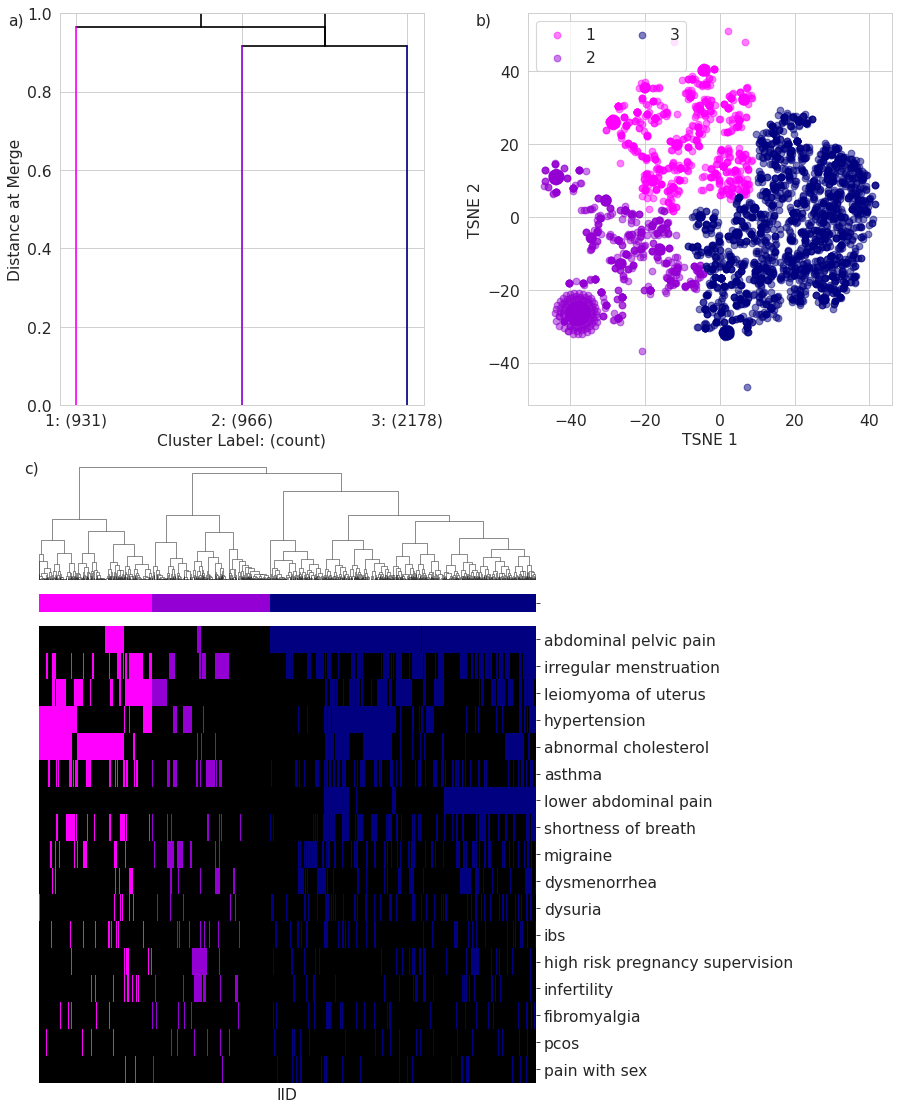

In [11]:
k = 3

# Big clustermap here
distArray = ssd.squareform(tsne_dist_mtx)
cluster_count_dict = clusters.value_counts()
count_cluster_dict = {v:k for k, v in cluster_count_dict.items()}
Z = linkage(distArray, method='complete')

col_order = genes_factors.mean().sort_values(ascending=False).index

plt.gcf().set_size_inches(15, 6)
plot_table = genes_factors.drop(outliers).transpose().copy()
plot_table = plot_table * (clusters.loc[plot_table.columns])
# plot_table = plot_table.loc[genes_factors.mean().sort_values(ascending=False).index]
plot_table = plot_table.loc[col_order]
plot_table.index = [s.replace('_', ' ') for s in plot_table.index]
cm = sns.clustermap(plot_table, col_linkage=Z, method='complete', metric='cosine',
                    col_colors=clusters.replace(dict(zip(np.arange(k)+1, colors))),
                    xticklabels=False, cmap=new_cmap2, row_cluster=False, yticklabels=True)
cm.ax_row_dendrogram.set_visible(False)
cm.ax_cbar.set_visible(False)
cm.ax_col_dendrogram.text(s='c)', x=0, y=1, ha='right', va='top', transform=cm.ax_col_dendrogram.transAxes)
plt.tight_layout()
cm.fig.subplots_adjust(top=0.6)
cm.fig.set_size_inches(13, 14)

# Dendrogram - figure 2a
# left bottom width height
ax = cm.fig.add_axes([0.2, 0.65, 0.35, 0.35])
distArray = ssd.squareform(tsne_dist_mtx)

cluster_count_dict = clusters.value_counts()
count_cluster_dict = {v:k for k, v in cluster_count_dict.items()}
Z = linkage(distArray, method='complete')
d = dendrogram(Z, p=k, truncate_mode='lastp', no_plot=True)

x_ticks = []
x_tick_labels = []

for x_list, y_list in zip(d['icoord'], d['dcoord']):
    print(x_list, y_list)
    ax.plot(x_list[1:3], y_list[1:3], c='k')
    if y_list[0] == 0:
        x_idx = int((x_list[0] - 5) // 10)
        leaf_label = d['ivl'][x_idx]
        x_ticks.append(x_list[0])
        leaf_count = int(leaf_label.replace('(', '').replace(')', ''))
        color = 'C' + str(count_cluster_dict[leaf_count] - 1)
        x_tick_labels.append(str(count_cluster_dict[leaf_count]) + ': ' + leaf_label)
        ax.plot(x_list[0:2], y_list[0:2], c=color)
    else:
        ax.plot(x_list[0:2], y_list[0:2], c='k')
    if y_list[3] == 0:
        x_idx = int((x_list[2] - 5) // 10)
        leaf_label = d['ivl'][x_idx]
        x_ticks.append(x_list[2])
        leaf_count = int(leaf_label.replace('(', '').replace(')', ''))
        color = 'C' + str(count_cluster_dict[leaf_count] - 1)
        x_tick_labels.append(str(count_cluster_dict[leaf_count]) + ': ' + leaf_label)
        ax.plot(x_list[2:4], y_list[2:4], c=color)
    else:
        ax.plot(x_list[2:4], y_list[2:4], c='k')

    if y_list[1] > 0.9:
        x_mean = (x_list[1] + x_list[2]) / 2
        ax.plot([x_mean, x_mean], [y_list[1], 1], c='k')

ax.set_ylim(0, 1)
ax.set_xticks(x_ticks, x_tick_labels)
ax.set_ylabel('Distance at Merge')
ax.set_xlabel('Cluster Label: (count)')
ax.text(s='a)', x=-0.1, y=1, ha='right', va='top', transform=ax.transAxes)

# TSNE figure 2b
ax = cm.fig.add_axes([0.65, 0.65, 0.35, 0.35])

for cluster, subDF in embedding.drop(outliers).groupby(clusters):
    ax.scatter(subDF['TSNE 1'], subDF['TSNE 2'], label=cluster, alpha=0.5)

ax.set_ylabel('TSNE 2')
ax.set_xlabel('TSNE 1')

ax.legend(loc='upper left', ncol=2)
# ax.set_title('Non-Genotyped PMBB TSNE Colored by Cluster')
ax.text(s='b)', x=-0.1, y=1, ha='right', va='top', transform=ax.transAxes)
plt.savefig('Manuscript_Plots/clustering_multipane_figure.png', bbox_inches='tight')
plt.show()

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

/home/guarelin/mambaforge/envs/py38/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std


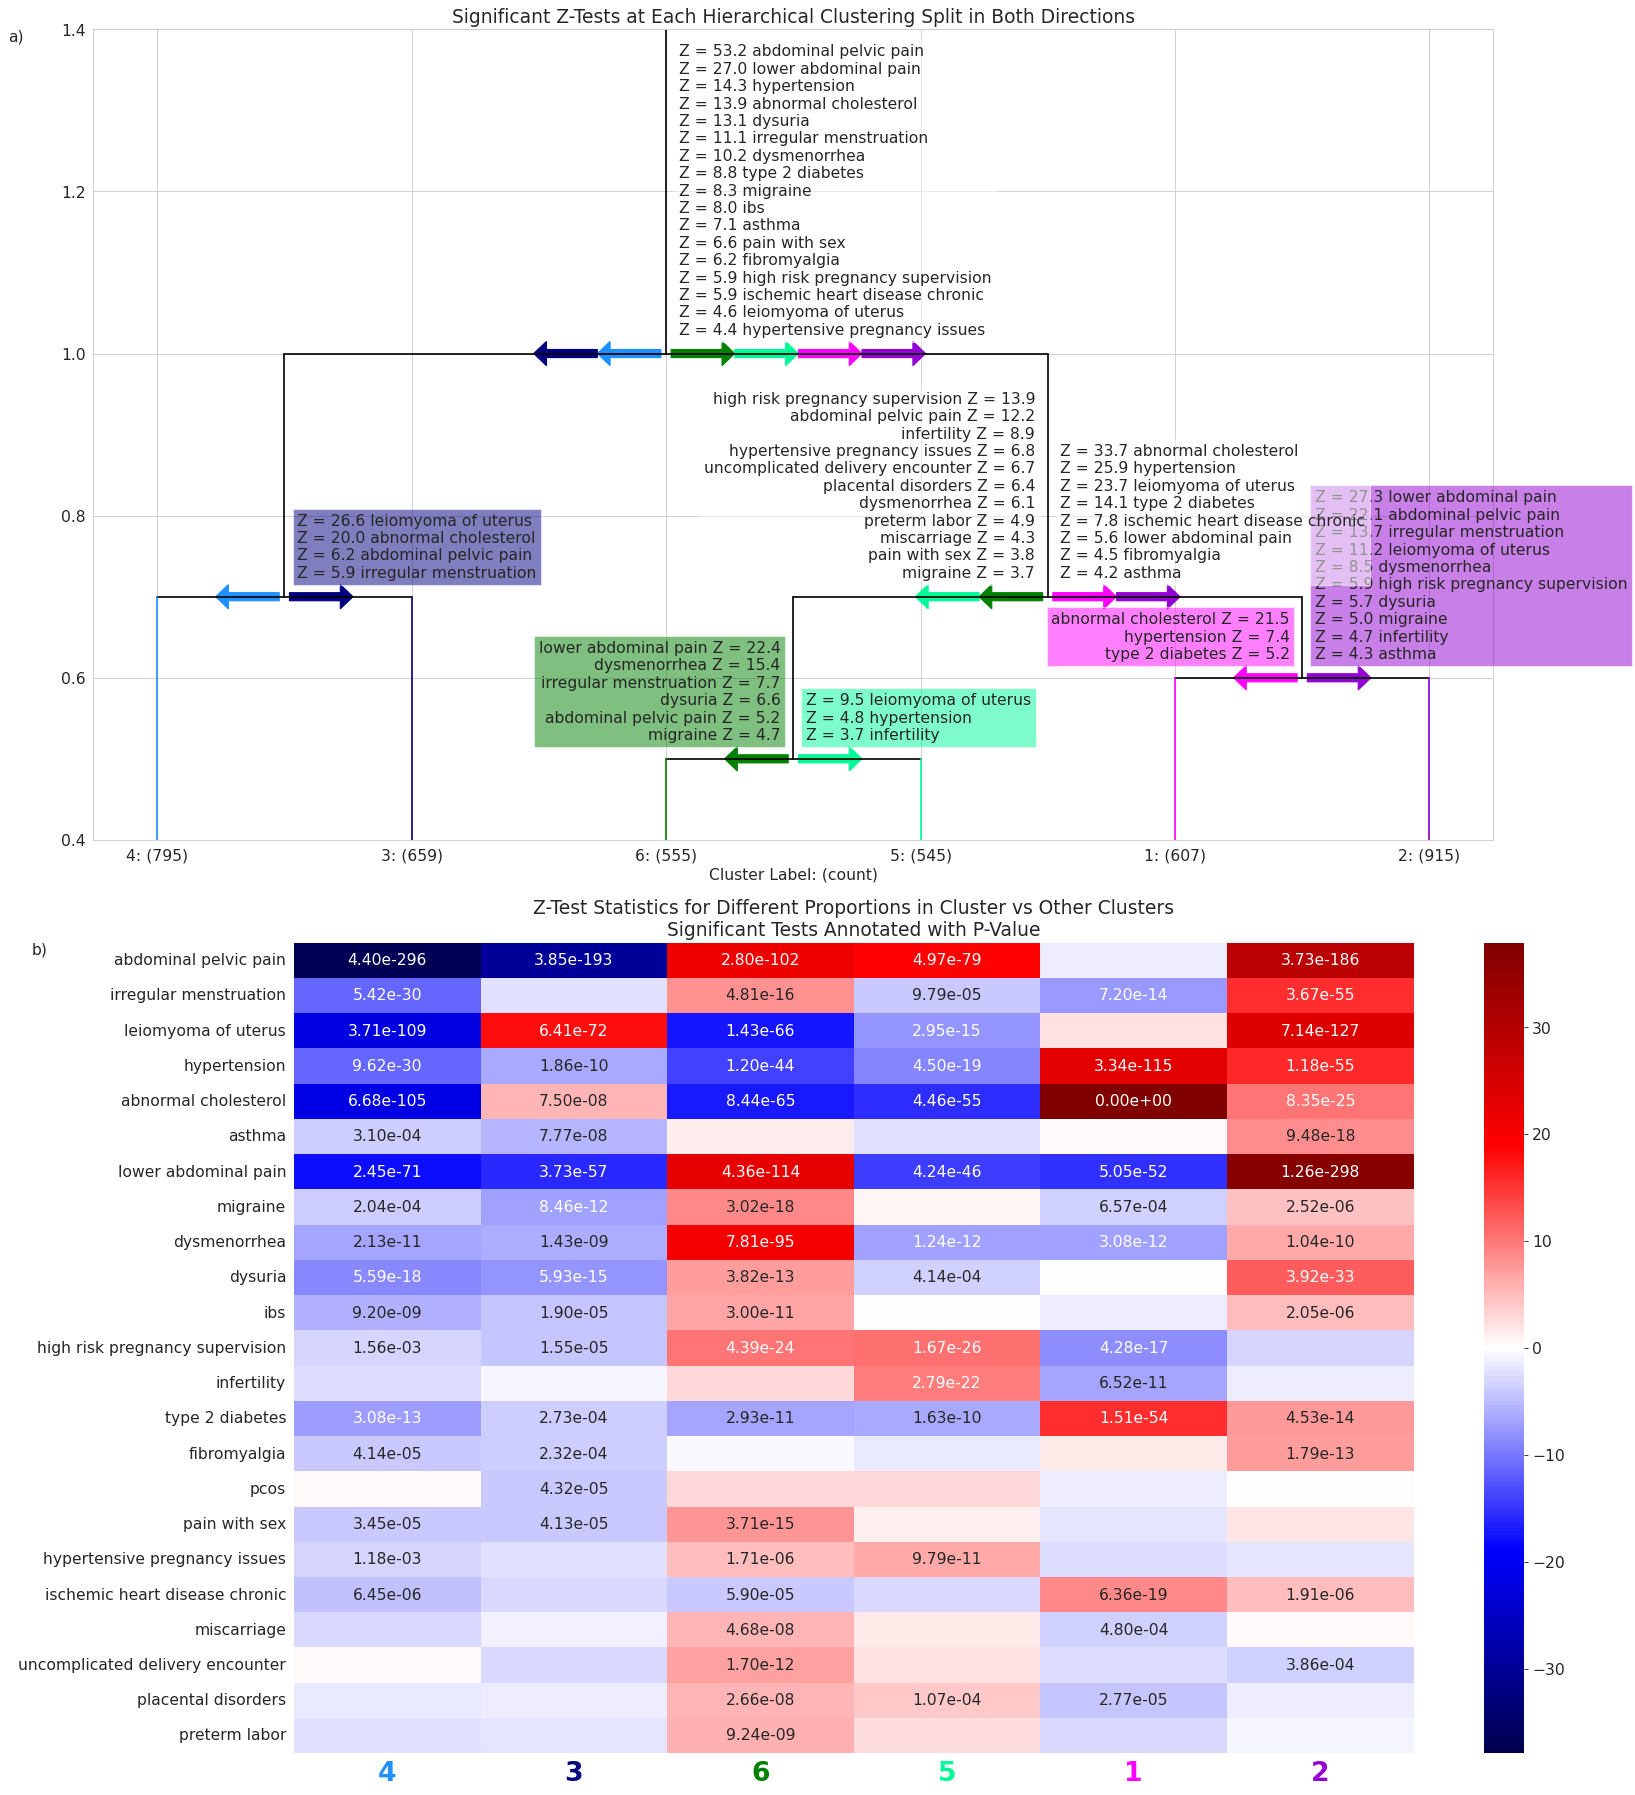

In [64]:
# left bottom width height
fig, axes = plt.subplots(nrows=2)

ax = axes[0]

distArray = ssd.squareform(tsne_dist_mtx)

cluster_count_dict = clusters.value_counts()
count_cluster_dict = {v:k for k, v in cluster_count_dict.items()}
Z = linkage(distArray, method='complete')
d = dendrogram(Z, p=k, truncate_mode='lastp', no_plot=True)

x_ticks = []
x_tick_labels = []

d['icoord_adjusted'] = [[0, 0, 15, 15],
                        [20, 20, 30, 30],
                        [45.0, 45.0, 55.0, 55.0],
                        [25, 25, 50, 50],
                        [7.5, 7.5, 35, 35]]
d['icoord_adjusted'] = d['icoord']

d['dcoord_adjusted'] = [[0.0, 0.7, 0.7, 0.0],
                        [0.0, 0.5, 0.5, 0.0],
                        [0.0, 0.6, 0.6, 0.0],
                        [0.5, 0.7, 0.7, 0.6],
                        [0.7, 1.0, 1.0, 0.7]]
# d['dcoord_adjusted'] = d['dcoord']

splits = [[[4],             [3], 0, 0.7],
          [[6],             [5], 1, 0.5],
          [[1],             [2], 2, 0.6],
          [[6, 5],       [1, 2], 3, 0.7],
          [[4, 3], [6, 5, 1, 2], 4, 1]]

for i, x_list, y_list in zip(list(range(len(d['icoord']))), d['icoord_adjusted'], d['dcoord_adjusted']):
    y_list[1] = splits[i][3]
    y_list[2] = splits[i][3]
    ax.plot(x_list[1:3], y_list[1:3], c='k')
    if y_list[0] == 0:
        x_idx = int((x_list[0] - 5) // 10)
        leaf_label = d['ivl'][x_idx]
        x_ticks.append(x_list[0])
        leaf_count = int(leaf_label.replace('(', '').replace(')', ''))
        color = 'C' + str(count_cluster_dict[leaf_count] - 1)
        x_tick_labels.append(str(count_cluster_dict[leaf_count]) + ': ' + leaf_label)
        ax.plot(x_list[0:2], y_list[0:2], c=color)
    else:
        ax.plot(x_list[0:2], y_list[0:2], c='k')
    if y_list[3] == 0:
        x_idx = int((x_list[2] - 5) // 10)
        leaf_label = d['ivl'][x_idx]
        x_ticks.append(x_list[2])
        leaf_count = int(leaf_label.replace('(', '').replace(')', ''))
        color = 'C' + str(count_cluster_dict[leaf_count] - 1)
        x_tick_labels.append(str(count_cluster_dict[leaf_count]) + ': ' + leaf_label)
        ax.plot(x_list[2:4], y_list[2:4], c=color)
    else:
        ax.plot(x_list[2:4], y_list[2:4], c='k')

    if y_list[1] > 0.9:
        x_mean = (x_list[1] + x_list[2]) / 2
        ax.plot([x_mean, x_mean], [y_list[1], 1.4], c='k')

ax.set_ylim(0, 1)
ax.set_xticks(x_ticks, x_tick_labels)
ax.set_ylabel(None)
ax.tick_params(axis='y', left=False)
ax.set_xlabel('Cluster Label: (count)')

for split_info in splits:
    clustersA, clustersB = split_info[0], split_info[1]
    popA = clusters.index[clusters.isin(clustersA)]
    popB = clusters.index[clusters.isin(clustersB)]
    split_y = split_info[3]

    split_ztests = pd.DataFrame()

    for trait in genes_factors.columns:
        succA = genes_factors.loc[popA, trait].sum()
        succB = genes_factors.loc[popB, trait].sum()

        nObsA = genes_factors.loc[popA, trait].count()
        nObsB = genes_factors.loc[popB, trait].count()

        z, p = proportions_ztest(count=[succA, succB], nobs=[nObsA, nObsB], alternative='two-sided')

        split_ztests.loc[trait, ['CaseA', 'CaseB', 'CountA', 'CountB', 'Z', 'P']] = [succA, succB, nObsA, nObsB, z, p]

    sig_p = 0.05 / len(genes_factors.columns) / 9
    coord_index = split_info[2]
    # split_y = d['dcoord'][coord_index][1]
    split_x = (d['icoord_adjusted'][coord_index][1] + d['icoord_adjusted'][coord_index][2]) / 2

    topA = split_ztests[(split_ztests['P'] < sig_p) & (split_ztests['Z'] > 0)].sort_values(by='P')
    split_strA = '\n'.join([' '.join([trait.replace('_', ' '), 'Z =', '{:.1f}'.format(abs(row['Z']))]) for trait, row in topA.iterrows()])
    t = ax.text(split_x - 0.5 , split_y + 0.02, split_strA, ha='right', va='bottom')
    if len(clustersA) == 1:
        t.set_bbox({'alpha': 0.5, 'facecolor': 'C' + str(int(clustersA[0] - 1))})
    else:
        t.set_bbox({'alpha': 0.5, 'facecolor': 'white'})

    topB = split_ztests[(split_ztests['P'] < sig_p) & (split_ztests['Z'] < 0)].sort_values(by='P')
    split_strB = '\n'.join([' '.join(['Z =', '{:.1f}'.format(abs(row['Z'])), trait.replace('_', ' ')]) for trait, row in topB.iterrows()])
    t = ax.text(split_x + 0.5 , split_y + 0.02, split_strB, ha='left', va='bottom')
    if len(clustersB) == 1:
        t.set_bbox({'alpha': 0.5, 'facecolor': 'C' + str(int(clustersB[0] - 1))})
    else:
        t.set_bbox({'alpha': 0.5, 'facecolor': 'white'})

    arrow_length = 2
    arrow_head_length = 0.5
    arrow_width = 0.01

    for i, cl in enumerate(clustersA):
        ax.arrow(x=split_x - 0.2 - (i * (arrow_length + arrow_head_length)), y=split_y, dx=-arrow_length, dy=0,
                 color='C' + str(int(cl - 1)), width=arrow_width, head_length=arrow_head_length)

    for i, cl in enumerate(clustersB):
        ax.arrow(x=split_x + 0.2 + (i * (arrow_length + arrow_head_length)), y=split_y, dx=arrow_length, dy=0,
                 color='C' + str(int(cl - 1)), width=arrow_width, head_length=arrow_head_length)

# print(ax.get_xlim())
# ax.set_xlim(-5, 55)
ax.set_ylim(0.4, 1.4)

cluster_ztests = pd.DataFrame(index=col_order)
cluster_ztests_P = pd.DataFrame(index=col_order)

for cluster in [4, 3, 6, 5, 1, 2]:
    popA = clusters.index[clusters == cluster]
    popB = clusters.index[clusters != cluster]

    for trait in genes_factors.columns:
        succA = genes_factors.loc[popA, trait].sum()
        succB = genes_factors.loc[popB, trait].sum()

        nObsA = genes_factors.loc[popA, trait].count()
        nObsB = genes_factors.loc[popB, trait].count()

        z, p = proportions_ztest(count=[succA, succB], nobs=[nObsA, nObsB], alternative='two-sided')

        cluster_ztests.loc[trait.replace('_', ' '), cluster] = z
        cluster_ztests_P.loc[trait.replace('_', ' '), cluster] = p

p_cutoff = 0.05 / len(genes_factors.columns)
cluster_ztests_P = cluster_ztests_P[cluster_ztests_P.min(axis=1) < p_cutoff]
cluster_ztests_P = cluster_ztests_P.mask(cluster_ztests_P > p_cutoff).applymap(lambda x: '{:.2e}'.format(x)).replace('nan', '')
col_order_z = [c.replace('_', ' ') for c in col_order if c.replace('_', ' ') in cluster_ztests_P.index]
cluster_ztests_P = cluster_ztests_P.loc[col_order_z]
cluster_ztests = cluster_ztests.loc[cluster_ztests_P.index]
sns.heatmap(cluster_ztests, annot=cluster_ztests_P, fmt='s', cmap='seismic',
            vmin=-cluster_ztests.abs().max().max(),
            vmax=cluster_ztests.abs().max().max(),
            ax=axes[1], yticklabels=True)

for i, ticklabel in enumerate(axes[1].get_xticklabels()):
    ticklabel.set_color('C' + str(int(ticklabel.get_text()) - 1))
    ticklabel.set_fontsize(24)
    ticklabel.set_fontweight('bold')

fig.set_size_inches(23, 23)

axes[1].set_title('Z-Test Statistics for Different Proportions in Cluster vs Other Clusters\nSignificant Tests Annotated with P-Value')
axes[0].set_title('Significant Z-Tests at Each Hierarchical Clustering Split in Both Directions')
plt.tight_layout()

axes[0].text(s='a)', x=-0.05, y=1, ha='right', va='top', transform=axes[0].transAxes)
axes[1].text(s='b)', x=-0.22, y=1, ha='right', va='top', transform=axes[1].transAxes)

# print(axes[0].get_position())
axes[0].set_position([0.05,
                      axes[0].get_position().y0,
                      axes[0].get_position().width,
                      axes[0].get_position().height])

plt.savefig('Manuscript_Plots/cluster_characterization.png', bbox_inches='tight')
plt.show()